## SPEI CALCULATION

SPEI index is one of the mostly used indices to assess drought conditions. We want to see how was the conditions for the D48 region, what the drought a contributing element in the forest change pattern?



In [77]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pyproj
import gzip
import rasterio

In [78]:
def UTM_to_Gauss_Kruger(x,y):
    src_crs = pyproj.CRS("EPSG:4326")  # Google Earth projection
    target_crs = pyproj.CRS("EPSG:31467")  # Gauss-Krüger 3rd meridian strip

    # Define transformation method and parameters
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)

    # Transform coordinates
    lon, lat = x, y  # Example longitude and latitude in decimal degrees
    x, y = transformer.transform(lon, lat)  # Transform to Gauss-Krüger 3rd meridian strip
    return x, y 

def UTM_to_EPSG3034(x,y):
    src_crs = pyproj.CRS("EPSG:4326")  # Google Earth projection
    target_crs = pyproj.CRS("EPSG:3034")  # EPSG:3034 

    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)

    lon, lat = x, y  # Example longitude and latitude in decimal degrees
    x, y = transformer.transform(lon, lat)  # Transform to Gauss-Krüger 3rd meridian strip
    return x, y 


def GetTimeFromFileName(fileDate):
    year_string = fileDate[0:4]
    year = int(year_string)
    month_string = fileDate[4:7]
    month = int(month_string)

    if (month == 1 or month==3 or month ==5 or month ==7 or month==8 or month==10 or month==12):
        return year_string +"-" + month_string +"-" + "31"
    elif (month == 4 or month==6 or month ==9 or month ==11):
        return year_string +"-" + month_string +"-" + "30"
    elif (year %4 == 0 &  month ==2):
        return year_string +"-" + month_string +"-" + "29"
    else:
        return year_string +"-" + month_string +"-" + "28"

def Parse_ASCIIFiles_To_DataSet(path , dataset_name):
    csv_files_decompressed = [gzip.open(os.path.join(file)) for file in os.scandir(path) if '.gz' in str(file)]

    dataarrays = []

    for csv_file in csv_files_decompressed:
        
        # Bounds of the file in the Gauss-Krüger-network of the Meridian strip 9 degrees East
        northing_above = 6103501 - 1000/2
        northing_below = 5237501 + 1000/2
        easting_left = 3280414 + 1000/2
        easting_right = 3934414 + 1000/2

        filedate = csv_file.name.split("_")[6].split(".")[0]
        datestring = GetTimeFromFileName(filedate)

        dataset_reader = rasterio.open(csv_file, driver='AAIGrid')

        dataset = dataset_reader.read()

        data_array = xr.Dataset(
        data_vars = dict(
            dataset_name=(["time", "lat", "lon"], dataset),
        ), 
        coords=dict(
            time= np.array([datestring], dtype='datetime64'),
            lat = -np.arange(0,dataset_reader.height)*1000+northing_above,
            lon = np.arange(0,dataset_reader.width)*1000 + easting_left),
        attrs=dict(
            resolution=dataset_reader.res,
            transform = dataset_reader.transform,
            nodata= dataset_reader.nodata,
            scale = dataset_reader.scales
        ))
        dataarrays.append(data_array)

    return xr.concat(dataarrays,'time').sortby("time")

def Parse_ASCIIFiles_To_DataArray(path, dataset_name, scale):
    csv_files_decompressed = [gzip.open(os.path.join(file)) for file in os.scandir(path) if '.gz' in str(file)]

    dataarrays = []

    for csv_file in csv_files_decompressed:
        
        # Bounds of Germany in the file in the Gauss-Krüger-network of the Meridian strip 9 degrees East
        northing_above = 6103501 - 1000/2
        northing_below = 5237501 + 1000/2
        easting_left = 3280414 + 1000/2
        easting_right = 3934414 + 1000/2

        filedate = csv_file.name.split("_")[6].split(".")[0]
        datestring = GetTimeFromFileName(filedate)

        dataset_reader = rasterio.open(csv_file, driver='AAIGrid')

        dataset = dataset_reader.read()
        dataset = dataset* scale
        dataset =np.ma.masked_where(dataset == -999.9, -9999)

        data_array = xr.DataArray(
        data=dataset,
        dims = ['time','lat', 'lon'],
        coords=dict(
            time= np.array([datestring], dtype='datetime64'),
            lat = -np.arange(0,dataset_reader.height)*1000+northing_above,
            lon = np.arange(0,dataset_reader.width)*1000 + easting_left),
        attrs=dict(
            resolution=dataset_reader.res,
            transform = dataset_reader.transform,
            nodata= dataset_reader.nodata,
            scale = dataset_reader.scales,
            units = "mm"
        ),
        name = dataset_name)
        dataarrays.append(data_array)

    return xr.concat(dataarrays,'time').sortby("time")
    

In [79]:
et_merged  = Parse_ASCIIFiles_To_DataArray(path = '/work/users/my982hzao/ET_RAW', dataset_name="ET", scale = 0.1)


<xarray.DataArray 'ET' (time: 74, lat: 866, lon: 654)>
array([[[-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        ...,
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9]],

       [[-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        ...,
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9]],

       [[-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        ...,
...
        ...,
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9]],

       [[-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        ...,
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9]],

       [[-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        ...,
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
        [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
  * lat      (lat) float64 6.103e+06 6.102e+06 6.101e+06 ... 5.239e+06 5.238e+06
  * lon      (lon) float64 3.281e+06 3.282e+06 3.283e+06 ... 3.933e+06 3.934e+06
Attributes:
    resolution:  (1000.0, 1000.0)
    transform:   | 1000.00, 0.00, 3280414.00|\n| 0.00,-1000.00, 6103501.00|\n...
    nodata:      -9999.0
    scale:       (1.0,)
    units:       mm

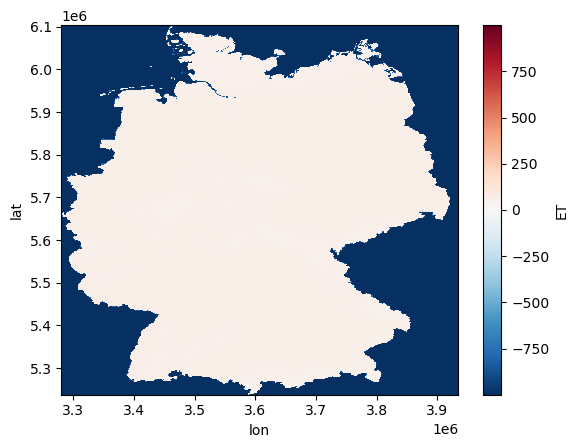

In [80]:
ET = et_merged.mean(dim='time')
ET.plot()


Apply Masks

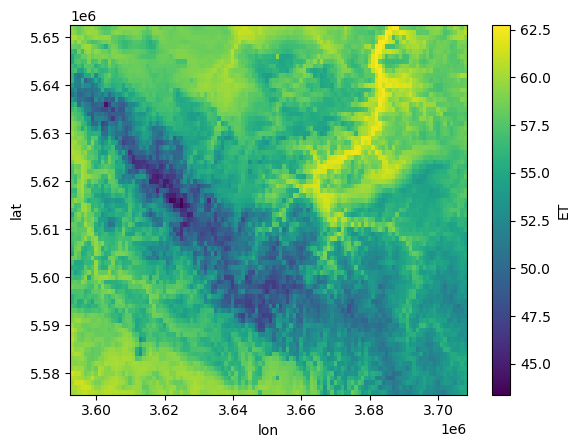

In [81]:

lon_min, lat_min, lon_max, lat_max = [10.294189,50.307024,11.961365,50.972242]
min_GK = UTM_to_Gauss_Kruger(lon_min, lat_min)
max_GK = UTM_to_Gauss_Kruger(lon_max, lat_max)
region_GK = (ET.lon >= min_GK[0]) & (ET.lat >= min_GK[1]) & (ET.lon <= max_GK[0]) & (ET.lat <= max_GK[1])

masked_ET = ET.where(region_GK).dropna(dim='lon', how='all').dropna(dim='lat', how='all')
masked_ET.plot()

### 2. Preciptation

In [82]:
path = '/work/users/jn906hluu/Climate/Precipitation'
list_of_datasets = [xr.open_dataset(os.path.join(file)) for file in os.scandir(path) if '.nc' in str(file)]

pr_ds = xr.concat(list_of_datasets, dim='time')

pr_monthly = pr_ds.sortby('time').resample(time='1M').mean()
pr_monthly

<xarray.Dataset>
Dimensions:             (y: 1100, x: 1200, time: 75, bnds: 2)
Coordinates:
    lon                 (y, x) float64 3.427 3.441 3.454 ... 21.36 21.37 21.39
    lat                 (y, x) float64 45.29 45.29 45.29 ... 55.21 55.21 55.21
  * x                   (x) float32 3.5e+06 3.502e+06 ... 4.698e+06 4.7e+06
  * y                   (y) float32 2.1e+06 2.102e+06 ... 3.198e+06 3.2e+06
  * time                (time) datetime64[ns] 2017-01-31 ... 2023-03-31
Dimensions without coordinates: bnds
Data variables:
    x_bnds              (time, x, bnds) float32 3.5e+06 3.501e+06 ... 4.7e+06
    y_bnds              (time, y, bnds) float32 2.1e+06 2.101e+06 ... 3.2e+06
    crs_HYRAS           (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    pr                  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    number_of_stations  (time) float64 5.254e+03 5.251e+03 ... 2.065e+03
Attributes: (12/20)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    conventionsURL:            http://cfconventions.org/Data/cf-conventions/c...
    institution:               Deutscher Wetterdienst (DWD)
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    creation_date:             created at 2022-12-03 19:17:38
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_2018_day_00638BA0D2
    filename:                  pr_hyras_1_2018_v5-0_de.nc

In [83]:
pr_ds

<xarray.Dataset>
Dimensions:             (time: 2252, bnds: 2, y: 1100, x: 1200)
Coordinates:
  * time                (time) datetime64[ns] 2018-01-01T18:00:00 ... 2019-12...
    lon                 (y, x) float64 3.427 3.441 3.454 ... 21.36 21.37 21.39
    lat                 (y, x) float64 45.29 45.29 45.29 ... 55.21 55.21 55.21
  * x                   (x) float32 3.5e+06 3.502e+06 ... 4.698e+06 4.7e+06
  * y                   (y) float32 2.1e+06 2.102e+06 ... 3.198e+06 3.2e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 2018-01-01T06:00:00 ... 2...
    x_bnds              (time, x, bnds) float32 3.5e+06 3.501e+06 ... 4.7e+06
    y_bnds              (time, y, bnds) float32 2.1e+06 2.101e+06 ... 3.2e+06
    crs_HYRAS           (time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    pr                  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    number_of_stations  (time) float64 5.2e+03 5.201e+03 ... 5.276e+03 5.275e+03
Attributes: (12/20)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    conventionsURL:            http://cfconventions.org/Data/cf-conventions/c...
    institution:               Deutscher Wetterdienst (DWD)
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    creation_date:             created at 2022-12-03 19:17:38
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_2018_day_00638BA0D2
    filename:                  pr_hyras_1_2018_v5-0_de.nc

In [84]:
# making the PR dataset more like the ET dataset and more compact
pr_monthly =pr_monthly.drop_vars(["x_bnds","y_bnds","crs_HYRAS","number_of_stations"])
pr_monthly =pr_monthly.drop(labels='2023-03-31',dim="time" )
pr_monthly

/tmp/ipykernel_2924590/3331778603.py:3: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  pr_monthly =pr_monthly.drop(labels='2023-03-31',dim="time" )


<xarray.Dataset>
Dimensions:  (y: 1100, x: 1200, time: 74)
Coordinates:
    lon      (y, x) float64 3.427 3.441 3.454 3.467 ... 21.34 21.36 21.37 21.39
    lat      (y, x) float64 45.29 45.29 45.29 45.29 ... 55.21 55.21 55.21 55.21
  * x        (x) float32 3.5e+06 3.502e+06 3.502e+06 ... 4.698e+06 4.7e+06
  * y        (y) float32 2.1e+06 2.102e+06 2.102e+06 ... 3.198e+06 3.2e+06
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
Data variables:
    pr       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/20)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    conventionsURL:            http://cfconventions.org/Data/cf-conventions/c...
    institution:               Deutscher Wetterdienst (DWD)
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    creation_date:             created at 2022-12-03 19:17:38
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_2018_day_00638BA0D2
    filename:                  pr_hyras_1_2018_v5-0_de.nc

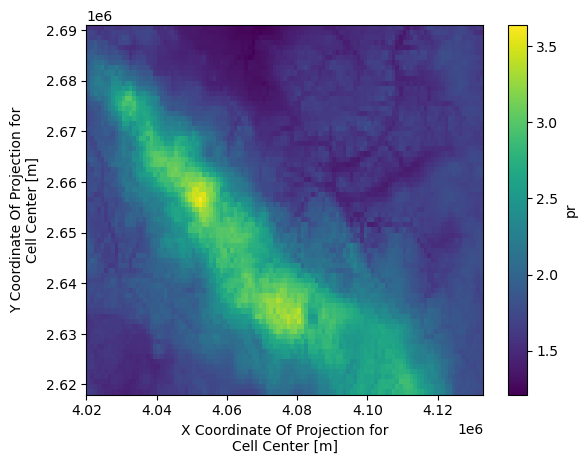

In [85]:
PR = pr_monthly.mean(dim='time')

min_EPSG3034 = UTM_to_EPSG3034(lon_min, lat_min)
max_EPSG3034 = UTM_to_EPSG3034(lon_max, lat_max)
region_EPSG3034 = (PR.x >= min_EPSG3034[0]) & (PR.y >= min_EPSG3034[1]) & (PR.x <= max_EPSG3034[0]) & (PR.y <= max_EPSG3034[1])

masked_PR = PR.where(region_EPSG3034).dropna(dim='x', how='all').dropna(dim='y', how='all')
masked_PR["pr"].plot()

In [94]:
masked_PR

<xarray.Dataset>
Dimensions:      (y: 73, x: 113)
Coordinates:
    lon          (y, x) float64 10.3 10.31 10.33 10.34 ... 11.92 11.94 11.95
    lat          (y, x) float64 50.31 50.31 50.31 50.31 ... 50.97 50.96 50.96
  * x            (x) float32 4.02e+06 4.022e+06 ... 4.132e+06 4.132e+06
  * y            (y) float32 2.618e+06 2.62e+06 2.62e+06 ... 2.69e+06 2.69e+06
    spatial_ref  int64 0
Data variables:
    pr           (y, x) float32 1.661 1.644 1.597 1.547 ... 1.577 1.625 1.562

In [93]:
masked_PR.rio.write_crs("EPSG:3034", inplace=True)
masked_ET.rio.write_crs("EPSG:31467", inplace=True)

et_matched_0 = masked_ET.rename({"lon": "x", "lat": "y"}).rio.reproject_match(masked_PR)
et_matched_0.rio.crs
et_matched_0

<xarray.DataArray 'ET' (y: 73, x: 113)>
array([[5.98716216e+001, 6.00256757e+001, 6.04364865e+001, ...,
        5.51067568e+001, 5.48810811e+001, 1.79769313e+308],
       [6.02472973e+001, 6.01121622e+001, 6.06891892e+001, ...,
        5.38472973e+001, 5.46648649e+001, 1.79769313e+308],
       [5.97986486e+001, 6.13594595e+001, 6.13662162e+001, ...,
        5.46351351e+001, 5.51527027e+001, 1.79769313e+308],
       ...,
       [1.79769313e+308, 5.82945946e+001, 5.82500000e+001, ...,
        6.01851351e+001, 6.03648649e+001, 5.94135135e+001],
       [1.79769313e+308, 5.97851351e+001, 5.85513514e+001, ...,
        6.01297297e+001, 5.98513514e+001, 6.06567568e+001],
       [1.79769313e+308, 6.03716216e+001, 6.02648649e+001, ...,
        5.95081081e+001, 5.84864865e+001, 5.99621622e+001]])
Coordinates:
  * x            (x) float32 4.02e+06 4.022e+06 ... 4.132e+06 4.132e+06
  * y            (y) float32 2.618e+06 2.62e+06 2.62e+06 ... 2.69e+06 2.69e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:  1.7976931348623157e+308